## Libraries

Important libraries used to apply time series techniques and visualize data properly.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

## Dataset

This dataset describes the minimum daily temperatures over 10 years (1981-1990) in the city Melbourne, Australia.

The units are in degrees Celsius and there are 3650 observations. The source of the data is credited as the Australian Bureau of Meteorology.

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv")

In [3]:
df.head()

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8


In [4]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

In [5]:
df.head()

,Temp
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3650 entries, 1981-01-01 to 1990-12-31
Data columns (total 1 columns):
Temp    3650 non-null float64
dtypes: float64(1)
memory usage: 57.0 KB


### Statistical Analysis

+ Overview

In [7]:
df.describe()

,Temp
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


+ Boxplot

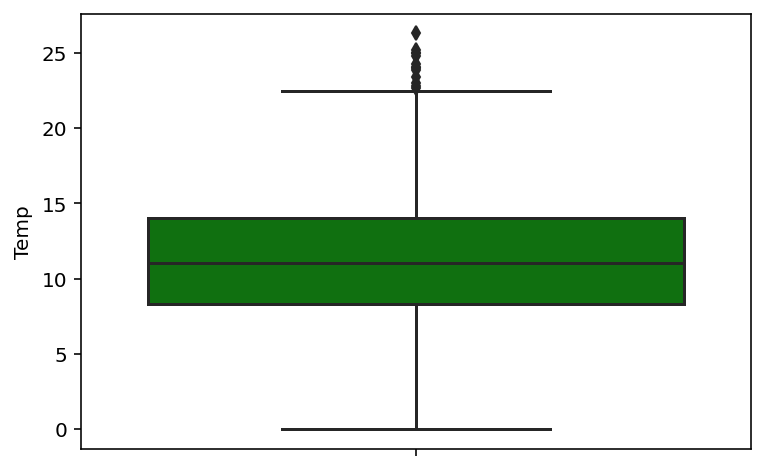

In [8]:
sns.boxplot(y="Temp", data=df, color="green")
plt.show()

+ Histogram

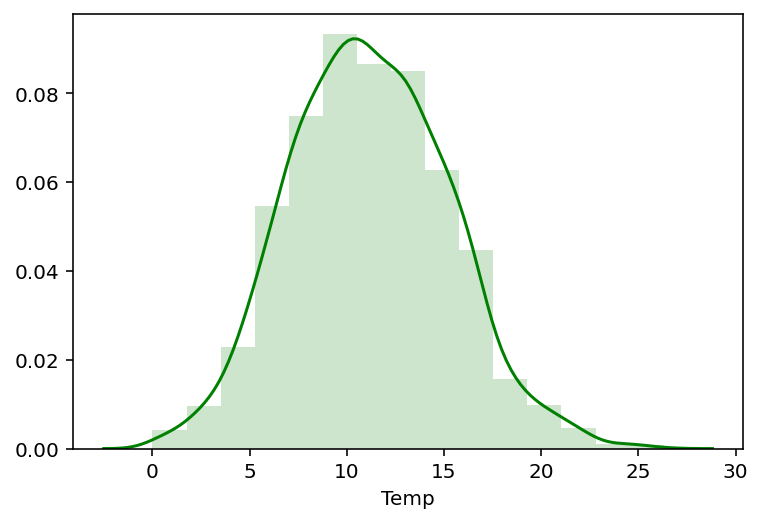

In [9]:
sns.distplot(a=df["Temp"], bins=15, color="green", hist_kws={"alpha":0.2, "linewidth":2})
plt.show()

+ Data according to periods of time

> Day

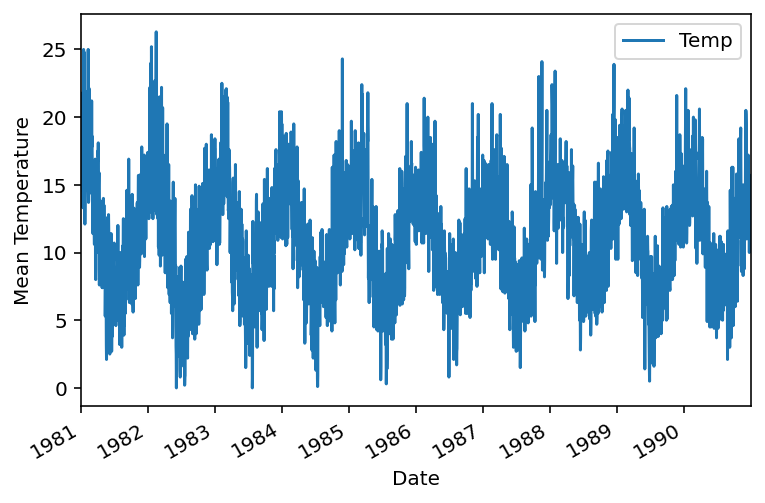

In [10]:
df.plot()
plt.ylabel("Mean Temperature")
plt.show()

> Month

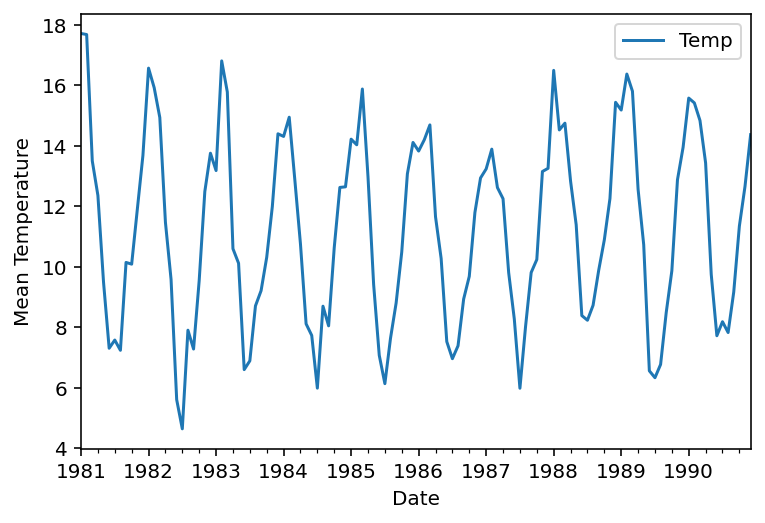

In [11]:
df.resample("M").mean().plot()
plt.ylabel("Mean Temperature")
plt.show()

> Year

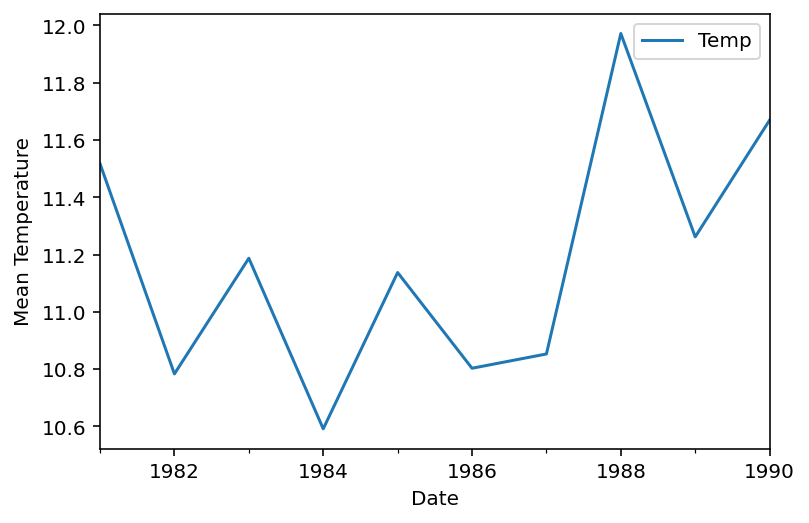

In [12]:
df.resample("Y").mean().plot()
plt.ylabel("Mean Temperature")
plt.show()

## Splitting dataset

It is important to split the data into a training and a validation set, in order to evaluate the possible models.

In [13]:
split_time = 3000

x_train = df.iloc[:split_time, -1]
time_train = np.arange(1, split_time+1)
x_test = df.iloc[split_time:, -1]
time_test = np.arange(split_time+1, len(df)+1)

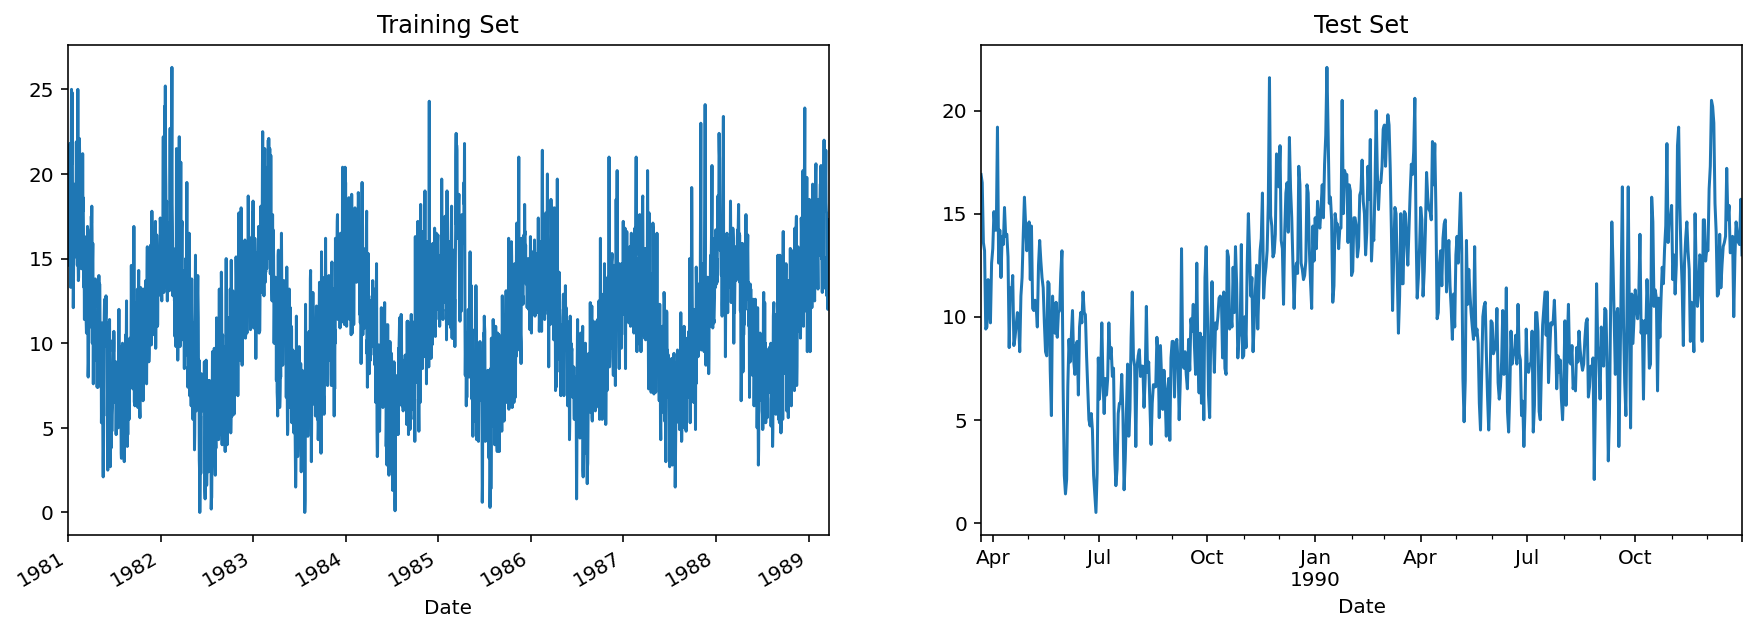

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

x_train.plot(ax=ax1)
ax1.set_title("Training Set")

x_test.plot(ax=ax2)
ax2.set_title("Test Set")
plt.show()

## Modeling Time Series

I will try to present some possible approaches and theis associated models while dealing with time series.

These models will be compared against each other by looking at MSE and MAE metrics. So let's define a function:

In [15]:
def evaluate_model(forecast, test_series):
    mse = tf.keras.metrics.mse(test_series, forecast).numpy()
    mae = tf.keras.metrics.mae(test_series, forecast).numpy()
    print(f"MSE: {mse:.3f}\nMAE: {mae:.3f}")

### 1. Naïve Forecasting

This is the most simple autoregressive model, at which we assume that the new value is equal to the previous time step.

$y(t) = y(t-1)$

In [16]:
forecast = df.shift(1)
test_forecast = forecast[split_time:]

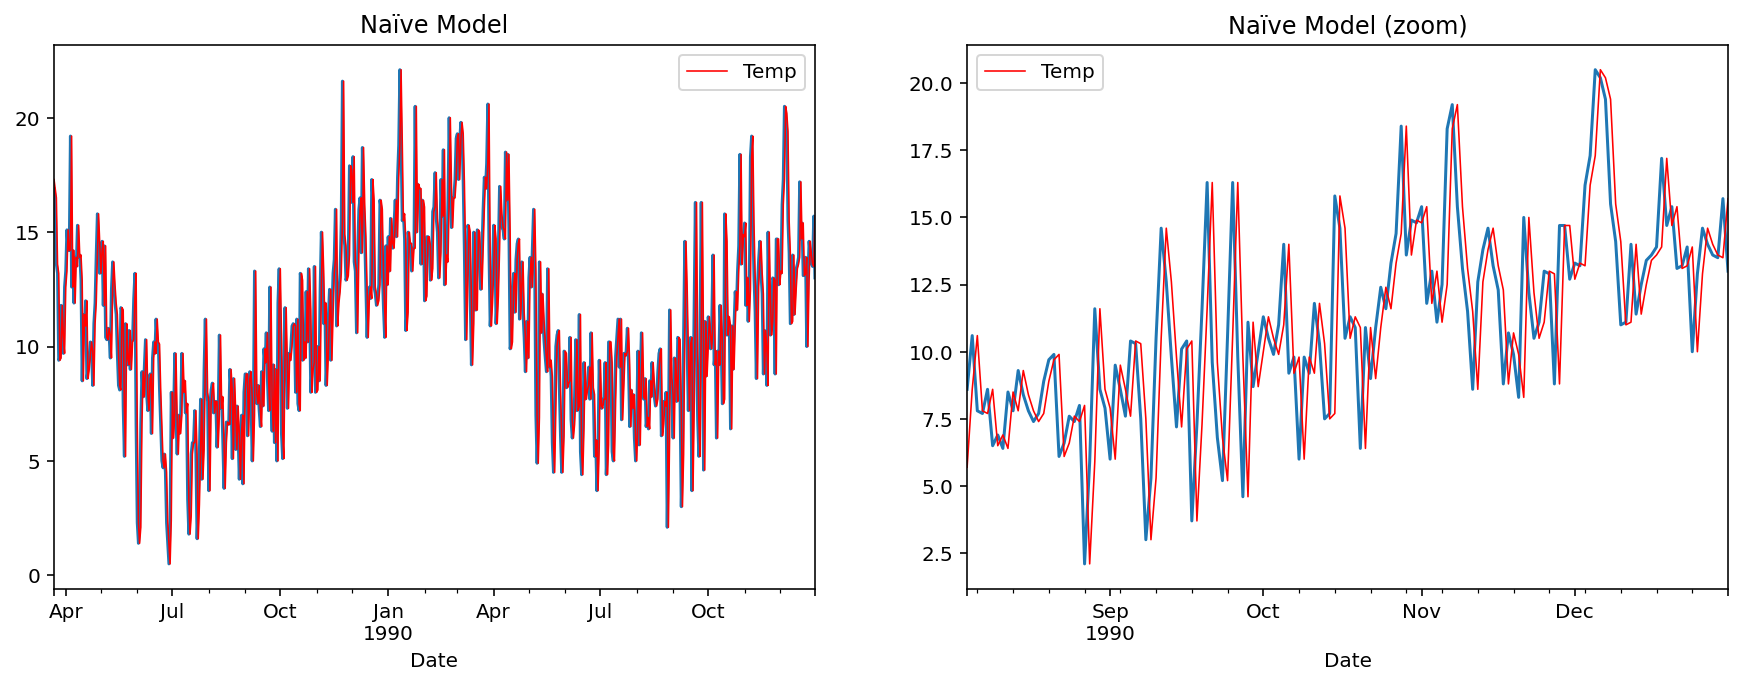

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

x_test.plot(ax=ax1)
test_forecast.plot(ax=ax1, color="red", linewidth=0.8)
ax1.set_title("Naïve Model")

x_test[-150:].plot(ax=ax2)
test_forecast[-150:].plot(ax=ax2, color="red", linewidth=0.8)
ax2.set_title("Naïve Model (zoom)")
plt.show()

In [18]:
evaluate_model(x_test.values, test_forecast.values[0])

MSE: 56.132
MAE: 6.581


### 2. Moving Average

We can just consider the mean of a given window size.

$y(t) = y_{mean}(t-window:t-1)$

In [19]:
window_size = 20

In [20]:
ma_forecast = df.rolling(window_size).mean().shift(1)

In [21]:
test_forecast = ma_forecast[split_time:]

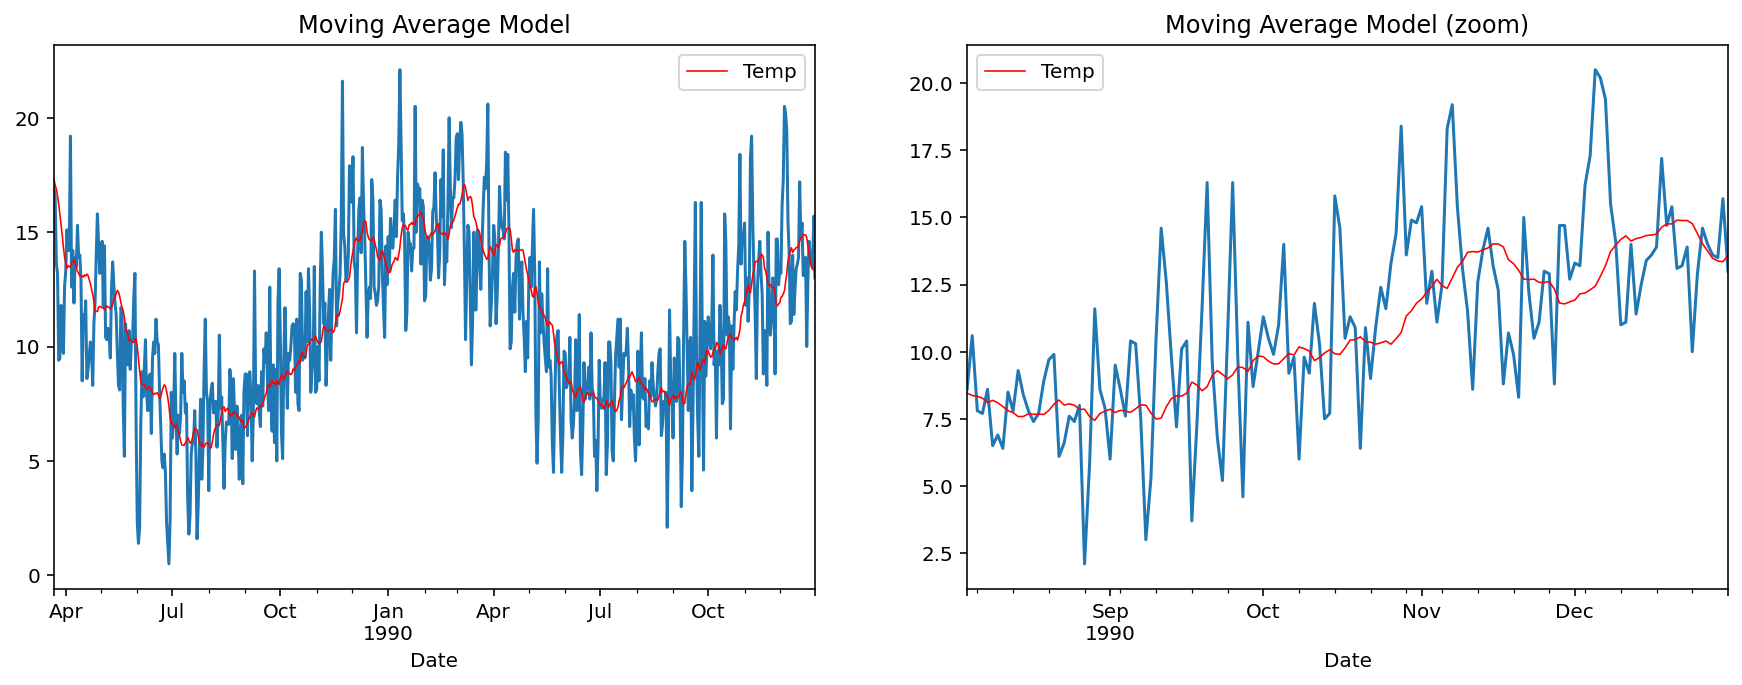

In [22]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

x_test.plot(ax=ax1)
test_forecast.plot(ax=ax1, color="red", linewidth=0.8)
ax1.set_title("Moving Average Model")

x_test[-150:].plot(ax=ax2)
test_forecast[-150:].plot(ax=ax2, color="red", linewidth=0.8)
ax2.set_title("Moving Average Model (zoom)")
plt.show()

In [23]:
evaluate_model(x_test.values, test_forecast.values[0])

MSE: 56.068
MAE: 6.577


### 3. Difference Moving Average + Last Period

We can just consider the mean of a given window size, by taking the **difference time series** and then add the previous period.

$y(t) = y_{mean.difference.ts}(t-window:t-1) + y_{previous}(t)$

In [24]:
difference_dataset = df.Temp.values[len(x_test):]-df.Temp.values[:-len(x_test)]
difference_df = pd.Series(data=difference_dataset, index=df.index[len(x_test):])

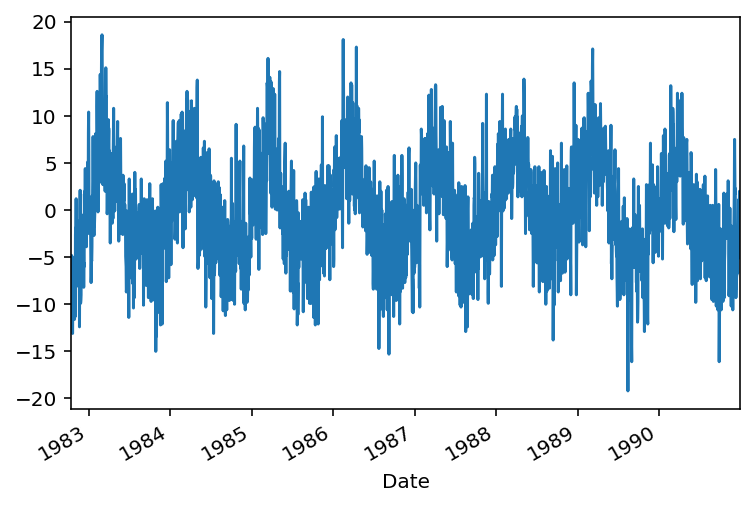

In [25]:
difference_df.plot();

In [26]:
window_size = 20

In [27]:
ma_forecast = difference_df.rolling(window_size).mean().shift(1)

In [28]:
test_forecast = ma_forecast[split_time-len(x_test):].values+df.iloc[split_time-len(x_test):split_time, -1].values
test_forecast = pd.Series(data=test_forecast, index=df.index[-len(x_test):])

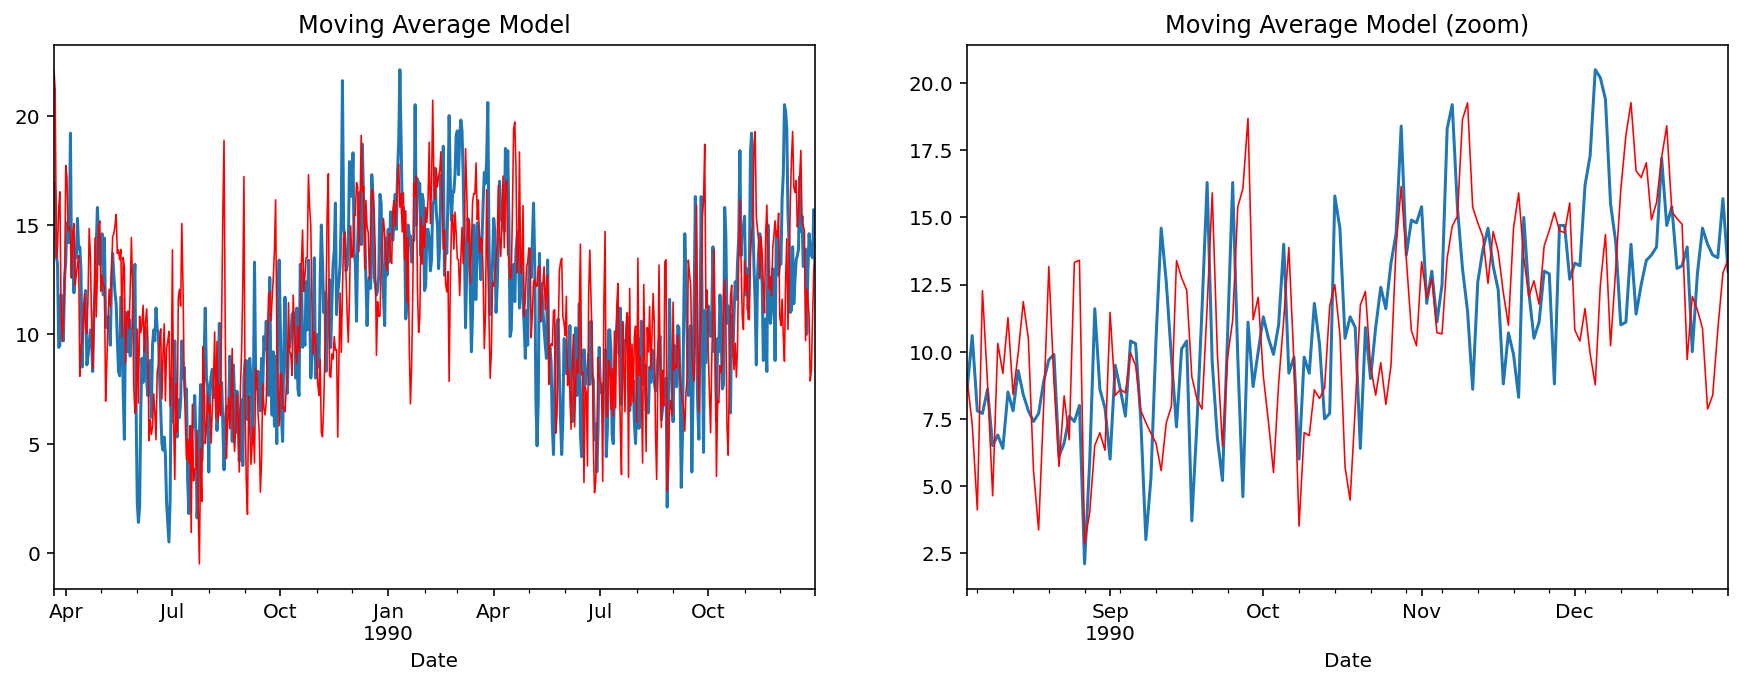

In [29]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

x_test.plot(ax=ax1)
test_forecast.plot(ax=ax1, color="red", linewidth=0.8)
ax1.set_title("Moving Average Model")

x_test[-150:].plot(ax=ax2)
test_forecast[-150:].plot(ax=ax2, color="red", linewidth=0.8)
ax2.set_title("Moving Average Model (zoom)")
plt.show()

In [30]:
evaluate_model(x_test.values, test_forecast.values)

MSE: 13.650
MAE: 2.909


### 4. Difference Moving Average + Last Period

We can just consider the mean of a given window size, by taking the **difference time series**, and then add the moving average of the previous period.

$y(t) = y_{mean.difference.ts}(t-window:t-1) + y_{mean}(t-window-period:t-period-1)$

In [31]:
difference_dataset = df.Temp.values[len(x_test):]-df.Temp.values[:-len(x_test)]
difference_df = pd.Series(data=difference_dataset, index=df.index[len(x_test):])

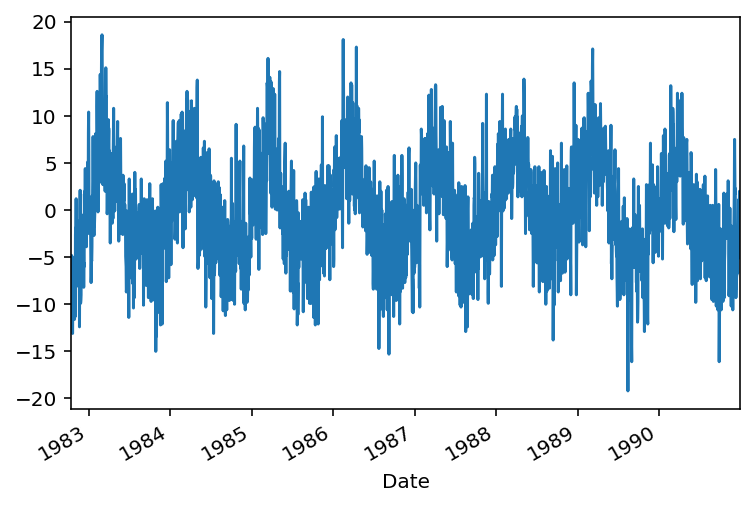

In [32]:
difference_df.plot();

In [33]:
window_size = 20

In [34]:
ma_forecast = difference_df.rolling(window_size).mean().shift(1)

In [35]:
to_add = (df.iloc[split_time-len(x_test)-5:split_time+5, -1]
            .rolling(10).mean().shift(1)[10:].values)

test_forecast = ma_forecast[split_time-len(x_test):].values + to_add
test_forecast = pd.Series(data=test_forecast, index=df.index[-len(x_test):])

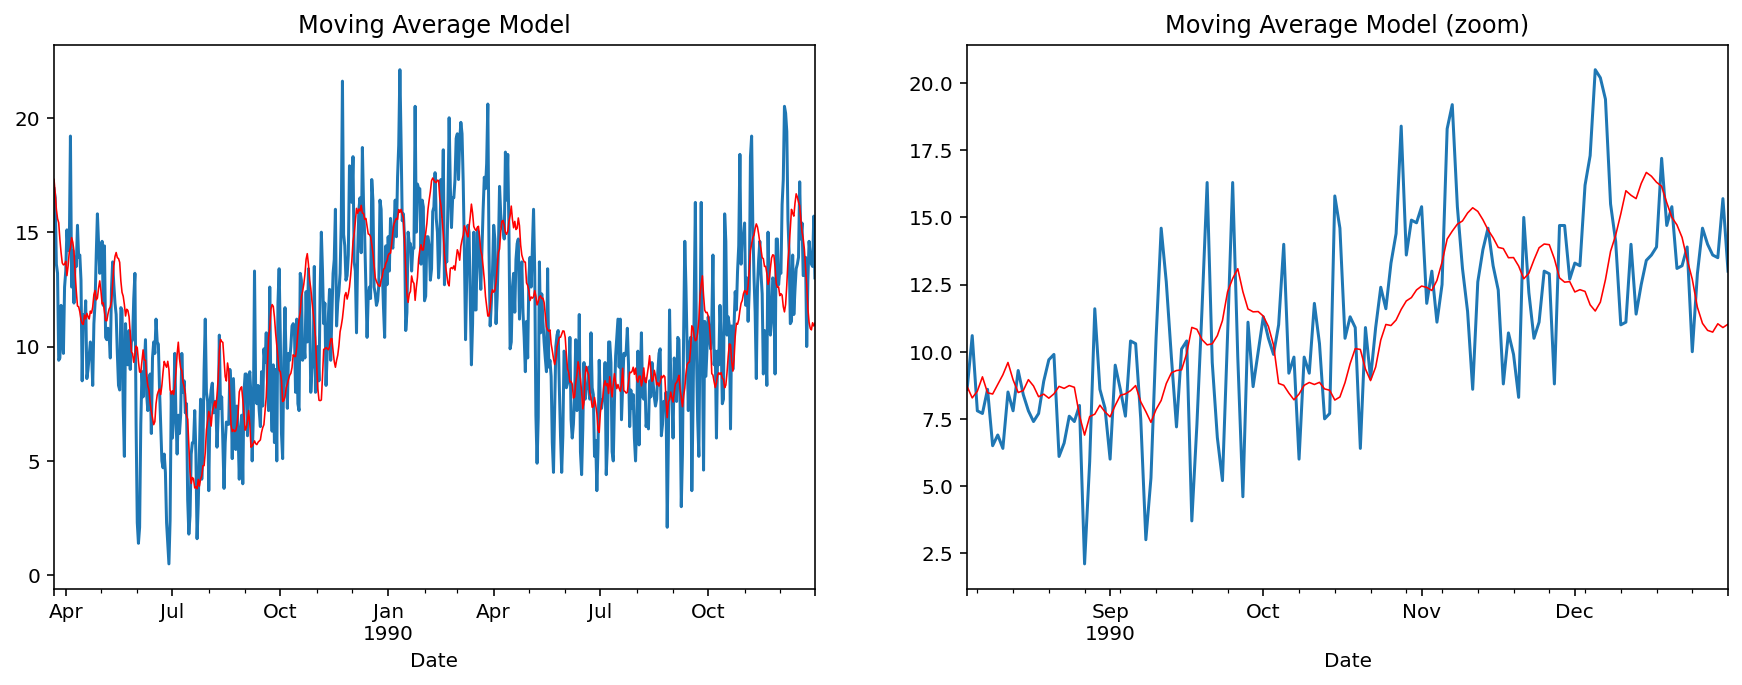

In [36]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

x_test.plot(ax=ax1)
test_forecast.plot(ax=ax1, color="red", linewidth=0.8)
ax1.set_title("Moving Average Model")

x_test[-150:].plot(ax=ax2)
test_forecast[-150:].plot(ax=ax2, color="red", linewidth=0.8)
ax2.set_title("Moving Average Model (zoom)")
plt.show()

In [37]:
evaluate_model(x_test.values, test_forecast.values)

MSE: 8.345
MAE: 2.271


### 5. DEEP LEARNING

First of all, we need to divide our dataset into sequences which the neural network can interpret as a sequence of values.

In [38]:
def windowed_series(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size+1))
    dataset = dataset.map(lambda w: (w[:-1], w[-1:]))
    return dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(1)

In [39]:
for x, y in windowed_series(df.Temp[-12:].values, 10, 2):
    print(x.numpy(), y.numpy())

[[13.1 13.2 13.9 10.  12.9 14.6 14.  13.6 13.5 15.7]
 [15.4 13.1 13.2 13.9 10.  12.9 14.6 14.  13.6 13.5]] [[13. ]
 [15.7]]


In [40]:
def windowed_series_prediction(series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    return dataset.batch(batch_size).prefetch(1)

In [41]:
for x in windowed_series_prediction(df.Temp[-11:].values, 10, 2):
    print(x.numpy())

[[13.1 13.2 13.9 10.  12.9 14.6 14.  13.6 13.5 15.7]
 [13.2 13.9 10.  12.9 14.6 14.  13.6 13.5 15.7 13. ]]


#### 5.1. ANN

Let's begin our study with deep learning for time series by using a simple densely connected neural network.

+ Parameters

In [42]:
window_size = 20
batch_size = 100

+ Dataset

In [43]:
x_train = windowed_series(x_train.values, window_size, batch_size)
test = windowed_series_prediction(df.Temp.values, window_size, batch_size)

+ Model with adjustable *learning rate*

In [50]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Dense(20, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [51]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [52]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch/20))

In [53]:
history = model.fit(x_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
30/30 [==============================] - 1s 34ms/step - loss: 157.0486
Epoch 2/100
30/30 [==============================] - 1s 20ms/step - loss: 55.1310
Epoch 3/100
30/30 [==============================] - 1s 19ms/step - loss: 16.5656
Epoch 4/100
30/30 [==============================] - 1s 18ms/step - loss: 10.9922
Epoch 5/100
30/30 [==============================] - 1s 19ms/step - loss: 10.8389
Epoch 6/100
30/30 [==============================] - 1s 22ms/step - loss: 10.7410
Epoch 7/100
30/30 [==============================] - 1s 20ms/step - loss: 10.6439
Epoch 8/100
30/30 [==============================] - 1s 20ms/step - loss: 10.5090
Epoch 9/100
30/30 [==============================] - 1s 25ms/step - loss: 10.3423
Epoch 10/100
30/30 [==============================] - 1s 21ms/step - loss: 10.1708
Epoch 11/100
30/30 [==============================] - 1s 21ms/step - loss: 9.9737
Epoch 12/100
30/30 [==============================] - 1s 21ms/step - loss: 9.7848
Epoch 13/100
3

30/30 [==============================] - 1s 20ms/step - loss: 16.6842


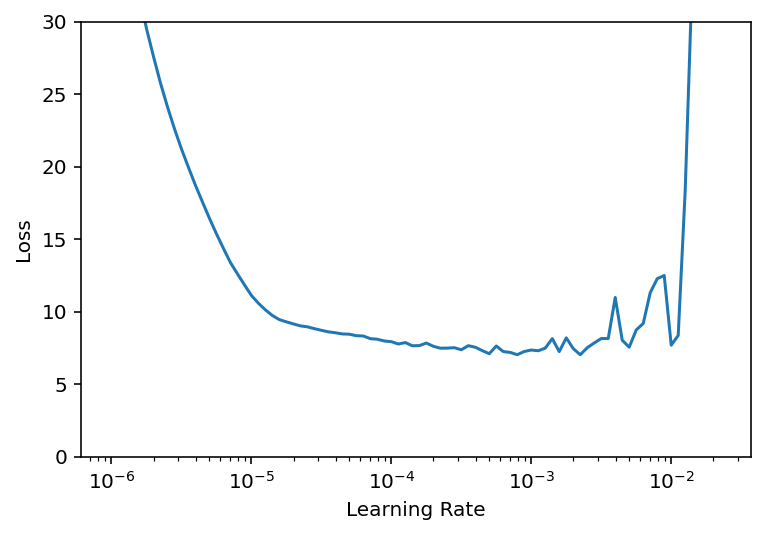

In [73]:
lrs = 1e-6 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.ylim(0,30)
plt.show()

In [56]:
optimal_lr = 1e-4

+ Final Model

In [57]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Dense(20, activation="relu", input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [58]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=optimal_lr, momentum=0.9))

In [59]:
history = model.fit(x_train, epochs=200)

Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 61.7983
Epoch 2/200
30/30 [==============================] - 0s 16ms/step - loss: 8.8155
Epoch 3/200
30/30 [==============================] - 0s 16ms/step - loss: 7.8812
Epoch 4/200
30/30 [==============================] - 0s 16ms/step - loss: 7.9240
Epoch 5/200
30/30 [==============================] - 1s 17ms/step - loss: 7.8372
Epoch 6/200
30/30 [==============================] - 0s 15ms/step - loss: 7.4918
Epoch 7/200
30/30 [==============================] - 0s 16ms/step - loss: 7.4600
Epoch 8/200
30/30 [==============================] - 0s 16ms/step - loss: 7.1396
Epoch 9/200
30/30 [==============================] - 0s 16ms/step - loss: 7.0569
Epoch 10/200
30/30 [==============================] - 0s 16ms/step - loss: 6.9004
Epoch 11/200
30/30 [==============================] - 1s 20ms/step - loss: 6.8141
Epoch 12/200
30/30 [==============================] - 1s 21ms/step - loss: 6.8262
Epoch 13/200
30/30 [====

30/30 [==============================] - 0s 16ms/step - loss: 5.9886
Epoch 101/200
30/30 [==============================] - 0s 15ms/step - loss: 5.9673
Epoch 102/200
30/30 [==============================] - 0s 16ms/step - loss: 5.9708
Epoch 103/200
30/30 [==============================] - 1s 18ms/step - loss: 5.9645
Epoch 104/200
30/30 [==============================] - 0s 16ms/step - loss: 6.0561
Epoch 105/200
30/30 [==============================] - 0s 15ms/step - loss: 5.9933
Epoch 106/200
30/30 [==============================] - 1s 21ms/step - loss: 5.9690
Epoch 107/200
30/30 [==============================] - 0s 15ms/step - loss: 5.9882
Epoch 108/200
30/30 [==============================] - 1s 17ms/step - loss: 6.0302
Epoch 109/200
30/30 [==============================] - 0s 16ms/step - loss: 5.9871
Epoch 110/200
30/30 [==============================] - 0s 15ms/step - loss: 5.9690
Epoch 111/200
30/30 [==============================] - 0s 15ms/step - loss: 6.0976
Epoch 112/200
30/3

30/30 [==============================] - 1s 17ms/step - loss: 5.9630
Epoch 199/200
30/30 [==============================] - 0s 16ms/step - loss: 5.9374
Epoch 200/200
30/30 [==============================] - 0s 16ms/step - loss: 6.0425


In [61]:
forecast = model.predict(test)

In [62]:
test_forecast = pd.Series(data=forecast[split_time-window_size:-1,0], index=df.index[split_time:])

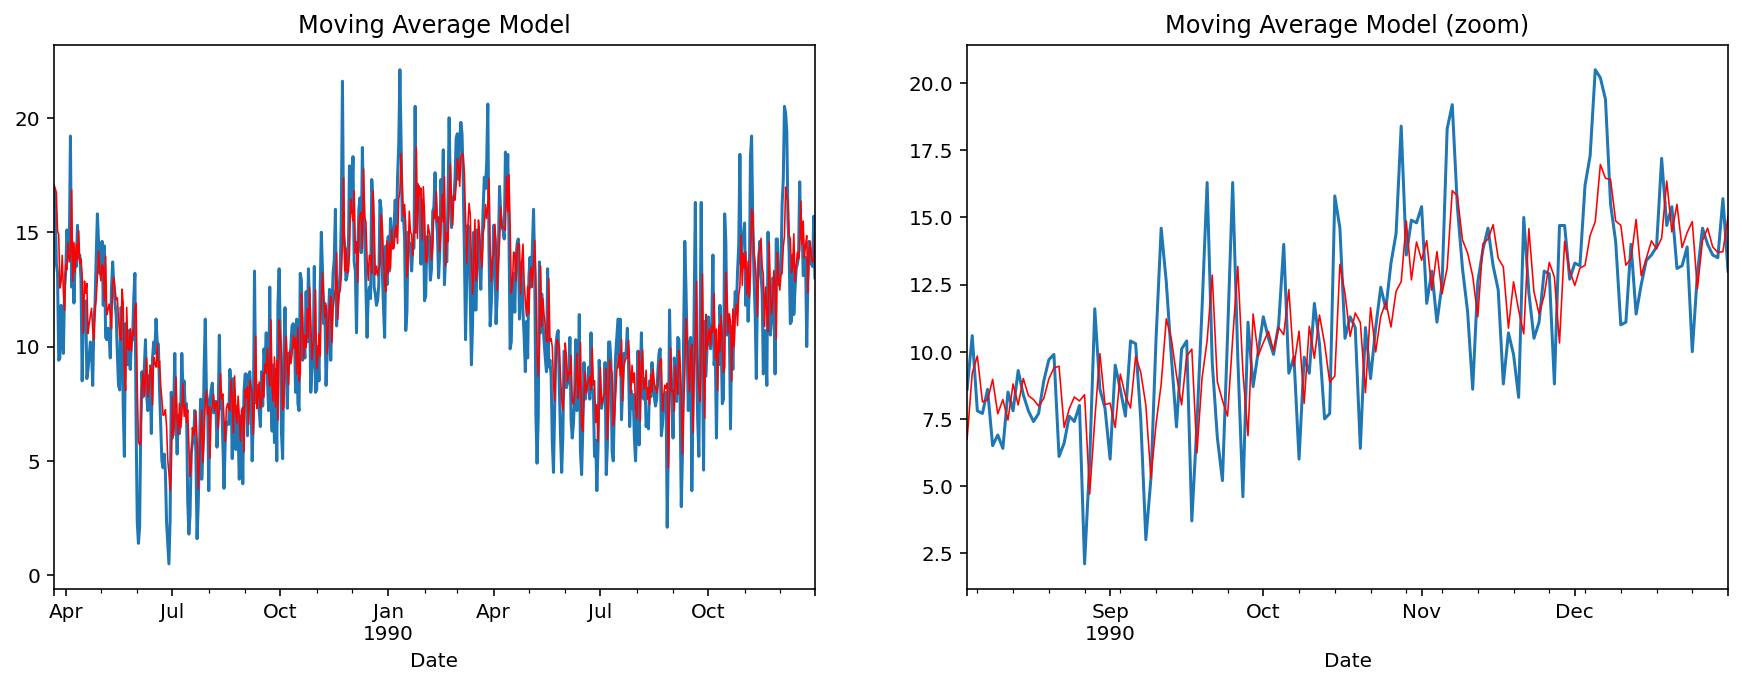

In [63]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

x_test.plot(ax=ax1)
test_forecast.plot(ax=ax1, color="red", linewidth=0.8)
ax1.set_title("Moving Average Model")

x_test[-150:].plot(ax=ax2)
test_forecast[-150:].plot(ax=ax2, color="red", linewidth=0.8)
ax2.set_title("Moving Average Model (zoom)")
plt.show()

In [64]:
evaluate_model(x_test.values, test_forecast.values)

MSE: 5.124
MAE: 1.775


#### 5.2. LSTM

We will use now a recurrent neural network, in order to take advantage of the memory within the sequence.

+ Parameters

In [65]:
window_size = 20
batch_size = 100

+ Model with adjustable *learning rate*

In [66]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [67]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))

In [68]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))

In [69]:
history = model.fit(x_train, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
30/30 [==============================] - 4s 122ms/step - loss: 65.9050
Epoch 2/100
30/30 [==============================] - 1s 32ms/step - loss: 44.3880
Epoch 3/100
30/30 [==============================] - 1s 32ms/step - loss: 37.1551
Epoch 4/100
30/30 [==============================] - 1s 32ms/step - loss: 34.2047
Epoch 5/100
30/30 [==============================] - 1s 34ms/step - loss: 31.8373
Epoch 6/100
30/30 [==============================] - 1s 32ms/step - loss: 29.5258
Epoch 7/100
30/30 [==============================] - 1s 32ms/step - loss: 27.6369
Epoch 8/100
30/30 [==============================] - 1s 33ms/step - loss: 25.7889
Epoch 9/100
30/30 [==============================] - 1s 31ms/step - loss: 24.1514
Epoch 10/100
30/30 [==============================] - 1s 32ms/step - loss: 22.6126
Epoch 11/100
30/30 [==============================] - 1s 33ms/step - loss: 21.2246
Epoch 12/100
30/30 [==============================] - 1s 33ms/step - loss: 19.9049
Epoch 13/100

30/30 [==============================] - 1s 48ms/step - loss: nan


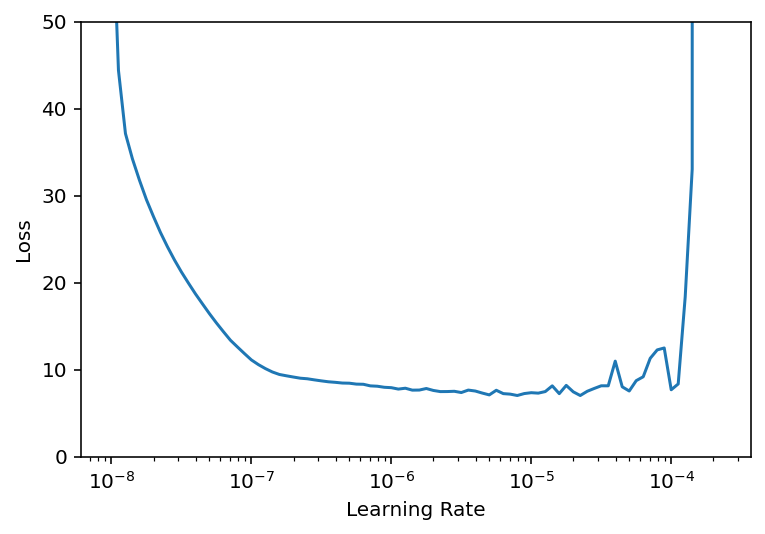

In [75]:
lrs = 1e-8 * (10**(np.arange(100)/20))
plt.semilogx(lrs, history.history["loss"])
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.ylim(0,50)
plt.show()

In [76]:
optimal_lr = 2e-5

+ Final Model

In [77]:
model = tf.keras.models.Sequential(layers=[
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.LSTM(20, return_sequences=True),
    tf.keras.layers.LSTM(20),
    tf.keras.layers.Dense(20, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

In [78]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=optimal_lr, momentum=0.9))

In [79]:
history = model.fit(x_train, epochs=200)

Epoch 1/200
30/30 [==============================] - 3s 116ms/step - loss: 657.9355
Epoch 2/200
30/30 [==============================] - 1s 30ms/step - loss: 24.0025
Epoch 3/200
30/30 [==============================] - 1s 30ms/step - loss: 15.5999
Epoch 4/200
30/30 [==============================] - 1s 31ms/step - loss: 14.7299
Epoch 5/200
30/30 [==============================] - 1s 35ms/step - loss: 12.8260
Epoch 6/200
30/30 [==============================] - 1s 32ms/step - loss: 10.2629
Epoch 7/200
30/30 [==============================] - 1s 29ms/step - loss: 8.5268
Epoch 8/200
30/30 [==============================] - 1s 34ms/step - loss: 7.2407
Epoch 9/200
30/30 [==============================] - 1s 31ms/step - loss: 7.3171
Epoch 10/200
30/30 [==============================] - 1s 30ms/step - loss: 7.3042
Epoch 11/200
30/30 [==============================] - 1s 31ms/step - loss: 7.5349
Epoch 12/200
30/30 [==============================] - 1s 41ms/step - loss: 7.2743
Epoch 13/200
30/3

30/30 [==============================] - 1s 38ms/step - loss: 6.1071
Epoch 101/200
30/30 [==============================] - 1s 37ms/step - loss: 6.3055
Epoch 102/200
30/30 [==============================] - 1s 36ms/step - loss: 6.6290
Epoch 103/200
30/30 [==============================] - 1s 36ms/step - loss: 6.5153
Epoch 104/200
30/30 [==============================] - 1s 36ms/step - loss: 6.3601
Epoch 105/200
30/30 [==============================] - 1s 35ms/step - loss: 6.4541
Epoch 106/200
30/30 [==============================] - 1s 36ms/step - loss: 7.0919
Epoch 107/200
30/30 [==============================] - 1s 36ms/step - loss: 7.0151
Epoch 108/200
30/30 [==============================] - 1s 37ms/step - loss: 7.4969
Epoch 109/200
30/30 [==============================] - 1s 36ms/step - loss: 6.5011
Epoch 110/200
30/30 [==============================] - 1s 38ms/step - loss: 6.5184
Epoch 111/200
30/30 [==============================] - 1s 37ms/step - loss: 6.2879
Epoch 112/200
30/3

30/30 [==============================] - 1s 49ms/step - loss: 6.3735: 0s - loss:
Epoch 199/200
30/30 [==============================] - 1s 39ms/step - loss: 6.2963
Epoch 200/200
30/30 [==============================] - 1s 35ms/step - loss: 6.1313


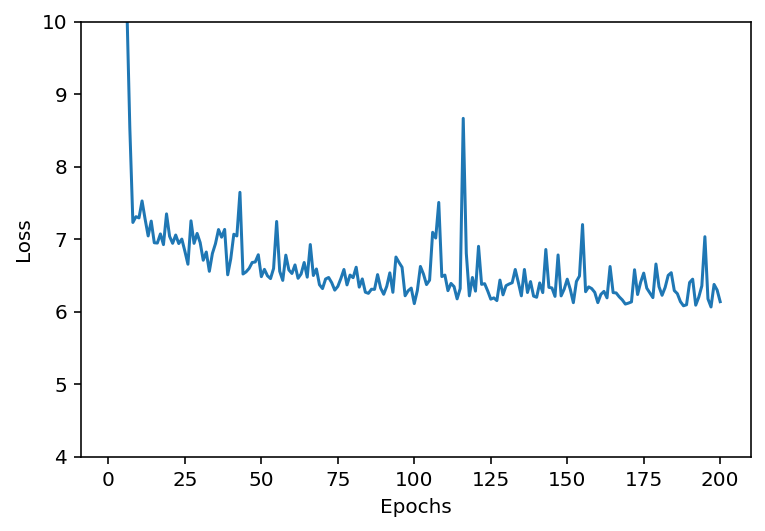

In [80]:
epochs = np.arange(1, 201)
plt.plot(epochs, history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((4,10))
plt.show()

In [81]:
forecast = model.predict(test)

In [82]:
test_forecast = pd.Series(data=forecast[split_time-window_size:-1,0], index=df.index[split_time:])

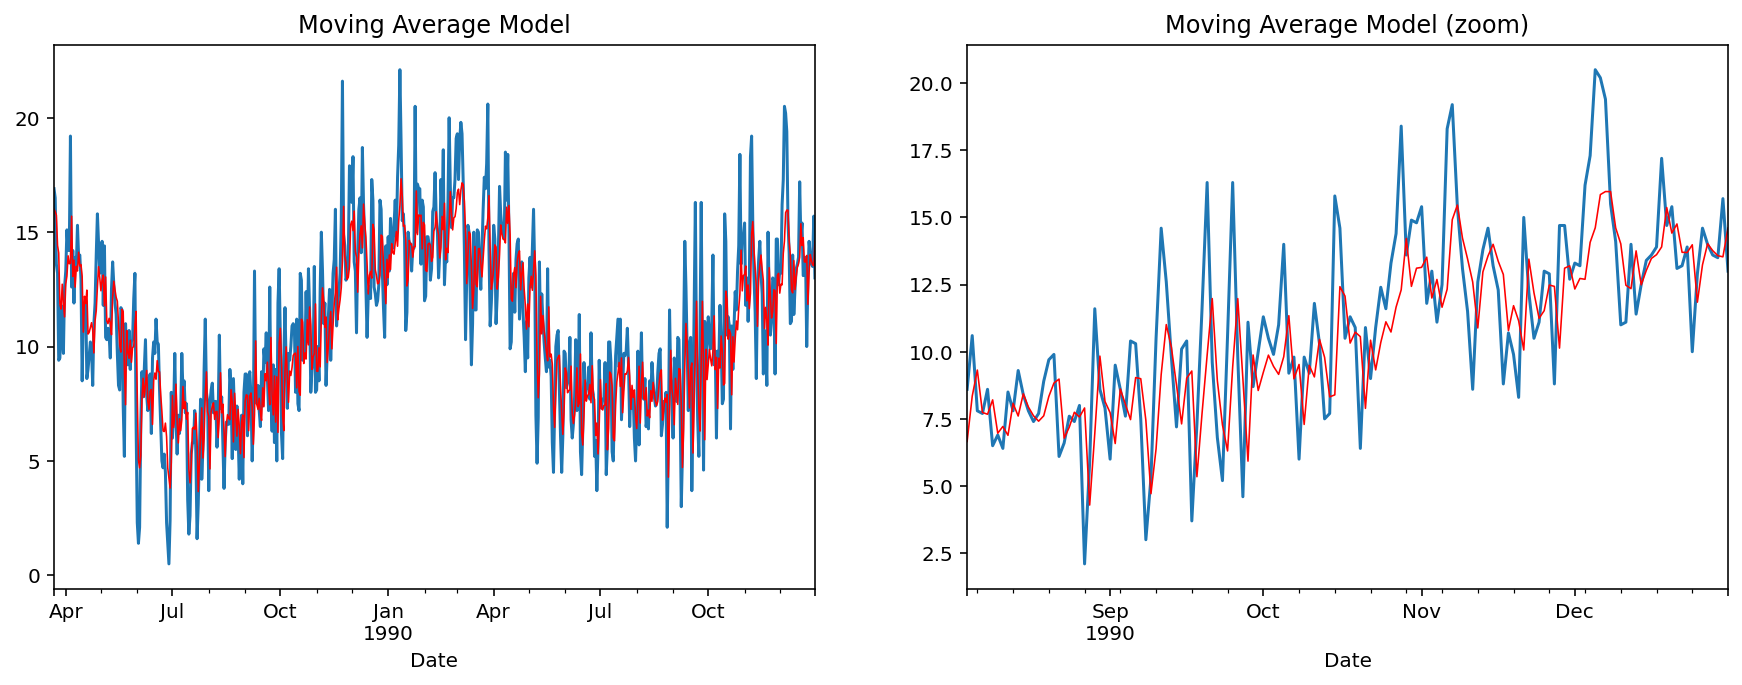

In [83]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))

x_test.plot(ax=ax1)
test_forecast.plot(ax=ax1, color="red", linewidth=0.8)
ax1.set_title("Moving Average Model")

x_test[-150:].plot(ax=ax2)
test_forecast[-150:].plot(ax=ax2, color="red", linewidth=0.8)
ax2.set_title("Moving Average Model (zoom)")
plt.show()

In [84]:
evaluate_model(x_test.values, test_forecast.values)

MSE: 5.064
MAE: 1.761


## THE END

Contact: GABRIEL FERNADES LUZ - gfluz94@gmail.com